TRANSACTION COSE ANALYSIS

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Dataset Loading

In [5]:
# Load trades dataset
trades = pd.read_csv("../Data/project2_trading.csv")

print("Dataset Shape:", trades.shape)
print("Columns:", trades.columns.tolist())

# Preview first rows
trades.head()


Dataset Shape: (30000, 20)
Columns: ['trade_id', 'instrument_id', 'timestamp', 'trade_type', 'order_type', 'strategy', 'quantity', 'price', 'execution_price', 'slippage_bps', 'commission_usd', 'market_impact_bps', 'pnl_usd', 'unrealized_pnl_usd', 'position_size', 'portfolio_weight', 'var_contribution', 'expected_shortfall', 'alpha', 'information_ratio']


,trade_id,instrument_id,timestamp,trade_type,order_type,strategy,quantity,price,execution_price,slippage_bps,commission_usd,market_impact_bps,pnl_usd,unrealized_pnl_usd,position_size,portfolio_weight,var_contribution,expected_shortfall,alpha,information_ratio
0,TRD_000001,INST_00516,2024-01-01 00:00:00.000000000,SELL,MARKET,PAIRS_TRADING,86786,2366.978206,4228.998055,45.693144,123.557611,27.127245,6303.279409,33727.550831,-5426,-0.019197,9951.045053,3630.846490,0.041462,-0.515848
1,TRD_000002,INST_00818,2024-01-01 00:11:39.863328777,BUY,LIMIT,PAIRS_TRADING,44460,245.020274,1939.500465,-13.856112,305.949746,4.590504,-18609.697852,5674.838624,22693,-0.049625,7307.215530,6161.016073,-0.007949,-1.324329
2,TRD_000003,INST_00283,2024-01-01 00:23:19.726657555,BUY,LIMIT,ARBITRAGE,69063,1182.449102,2909.052347,13.285065,439.862472,13.544003,24114.391997,-8033.113639,16986,-0.031285,964.660535,7325.327681,0.030110,2.973389
3,TRD_000004,INST_00138,2024-01-01 00:34:59.589986332,SELL,STOP_LIMIT,PAIRS_TRADING,5099,3582.864991,717.500193,19.825520,151.256672,8.038818,85492.858142,39938.159794,-5105,-0.097653,4481.309588,14672.750073,0.001169,0.471564
4,TRD_000005,INST_00931,2024-01-01 00:46:39.453315110,SELL,MARKET,MARKET_MAKING,16791,434.698012,3995.291578,-20.161252,194.567574,13.333377,-27824.693952,-2649.711967,-18134,0.035406,2501.407625,4633.071787,0.035962,-0.415628


Calculate Slippage & Market Impact

In [6]:
# Slippage Value
trades["slippage_value"] = (trades["execution_price"] - trades["price"]) * trades["quantity"]

# Total Cost = Slippage + Commissions
trades["cost_value"] = trades["slippage_value"] + trades["commission_usd"]

# Market Impact (convert bps to value)
trades["market_impact_value"] = trades["market_impact_bps"] / 10000 * trades["execution_price"] * trades["quantity"]

# Timing Effect (expected vs executed)
trades["timing_value"] = (trades["price"] - trades["execution_price"]) * trades["quantity"]

trades[["execution_price","price","slippage_value","cost_value","market_impact_value","timing_value"]].head()


,execution_price,price,slippage_value,cost_value,market_impact_value,timing_value
0,4228.998055,2366.978206,1.615973e+08,1.615974e+08,995618.243567,-1.615973e+08
1,1939.500465,245.020274,7.533659e+07,7.533690e+07,39584.003997,-7.533659e+07
2,2909.052347,1182.449102,1.192444e+08,1.192448e+08,272109.694687,-1.192444e+08
3,717.500193,3582.864991,-1.461050e+07,-1.461034e+07,2941.028571,1.461050e+07
4,3995.291578,434.698012,5.978593e+07,5.978612e+07,89446.882161,-5.978593e+07


Attribute P&L (Alpha, Beta, Cost, Timing)

In [7]:
# If alpha already exists, use it; else compute
if "alpha" in trades.columns:
    trades["beta_value"] = trades["pnl_usd"] - trades["alpha"]
else:
    trades["beta_value"] = 0

# Recompute alpha (audit-ready)
trades["alpha_value"] = trades["pnl_usd"] - trades["beta_value"] + trades["cost_value"] - trades["timing_value"]

trades[["pnl_usd","alpha_value","beta_value","cost_value","timing_value"]].head()


,pnl_usd,alpha_value,beta_value,cost_value,timing_value
0,6303.279409,3.231946e+08,6303.237947,1.615974e+08,-1.615973e+08
1,-18609.697852,1.506735e+08,-18609.689903,7.533690e+07,-7.533659e+07
2,24114.391997,2.384892e+08,24114.361887,1.192448e+08,-1.192444e+08
3,85492.858142,-2.922084e+07,85492.856973,-1.461034e+07,1.461050e+07
4,-27824.693952,1.195720e+08,-27824.729915,5.978612e+07,-5.978593e+07


Weekly Summary

In [8]:
# Convert timestamp → datetime
trades["timestamp"] = pd.to_datetime(trades["timestamp"], errors="coerce")
trades["_week"] = trades["timestamp"].dt.strftime("%Y-%U")

# Weekly grouping
weekly = trades.groupby("_week").agg(
    avg_slippage_bps=("slippage_bps","mean"),
    total_slippage_value=("slippage_value","sum"),
    total_commission=("commission_usd","sum"),
    avg_market_impact_bps=("market_impact_bps","mean"),
    total_market_impact_value=("market_impact_value","sum"),
    total_pnl=("pnl_usd","sum"),
    total_alpha=("alpha_value","sum"),
    total_beta=("beta_value","sum"),
    total_cost=("cost_value","sum"),
    total_timing=("timing_value","sum")
).reset_index()

weekly.head()


,_week,avg_slippage_bps,total_slippage_value,total_commission,avg_market_impact_bps,total_market_impact_value,total_pnl,total_alpha,total_beta,total_cost,total_timing
0,2024-00,0.655484,4.461020e+09,184037.195541,14.936657,1.452159e+08,1.803941e+07,8.922223e+09,1.803940e+07,4.461204e+09,-4.461020e+09
1,2024-01,-0.567570,6.154287e+08,207198.739355,15.405792,1.762278e+08,2.272536e+07,1.231065e+09,2.272535e+07,6.156359e+08,-6.154287e+08
2,2024-02,0.867636,-2.749035e+09,219376.937649,14.999330,1.614620e+08,2.171985e+07,-5.497851e+09,2.171984e+07,-2.748816e+09,2.749035e+09
3,2024-03,-0.268347,-2.190863e+07,214347.742619,14.879883,1.500538e+08,2.073028e+07,-4.360291e+07,2.073026e+07,-2.169429e+07,2.190863e+07
4,2024-04,1.384006,-1.474537e+09,213566.553131,15.190447,1.581091e+08,2.131052e+07,-2.948860e+09,2.131051e+07,-1.474323e+09,1.474537e+09


Weekly slippage trend

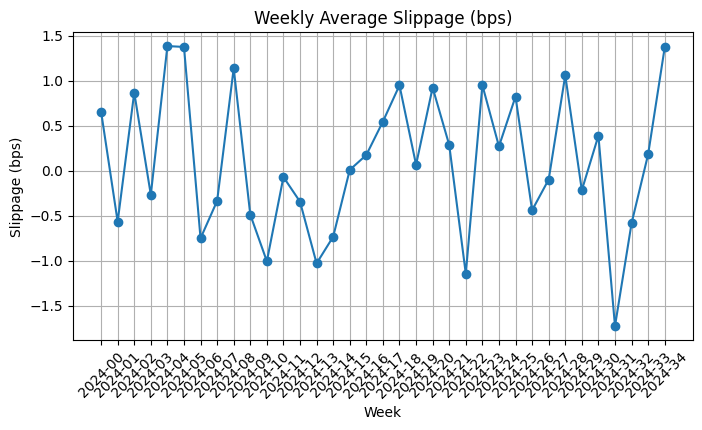

In [9]:
plt.figure(figsize=(8,4))
plt.plot(weekly["_week"], weekly["avg_slippage_bps"], marker="o")
plt.title("Weekly Average Slippage (bps)")
plt.xlabel("Week")
plt.ylabel("Slippage (bps)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Weekly cost trend

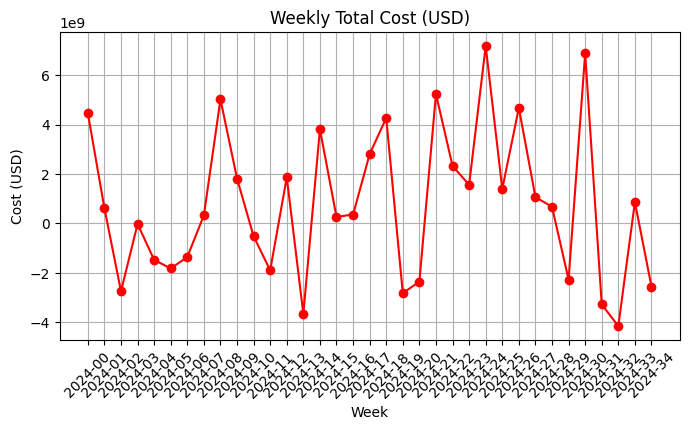

In [10]:
plt.figure(figsize=(8,4))
plt.plot(weekly["_week"], weekly["total_cost"], marker="o", color="red")
plt.title("Weekly Total Cost (USD)")
plt.xlabel("Week")
plt.ylabel("Cost (USD)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Strategy Performance

In [11]:
strategy_perf = trades.groupby("strategy").agg(
    avg_slippage_bps=("slippage_bps","mean"),
    total_pnl=("pnl_usd","sum"),
    total_cost=("cost_value","sum")
).reset_index()

print("Strategy Performance:")
display(strategy_perf)

Strategy Performance:


,strategy,avg_slippage_bps,total_pnl,total_cost
0,ARBITRAGE,-0.309642,1.463397e+08,1.003283e+10
1,MARKET_MAKING,0.206775,1.484083e+08,-2.643562e+09
2,MEAN_REVERSION,0.658748,1.435706e+08,1.116098e+10
3,MOMENTUM,-0.405027,1.540985e+08,1.713761e+09
4,PAIRS_TRADING,0.336117,1.462164e+08,6.272958e+09


Strategy Bar Charts

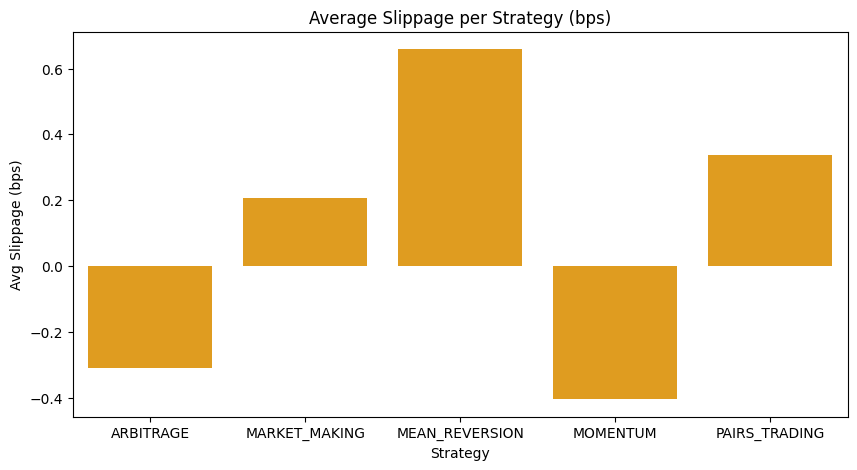

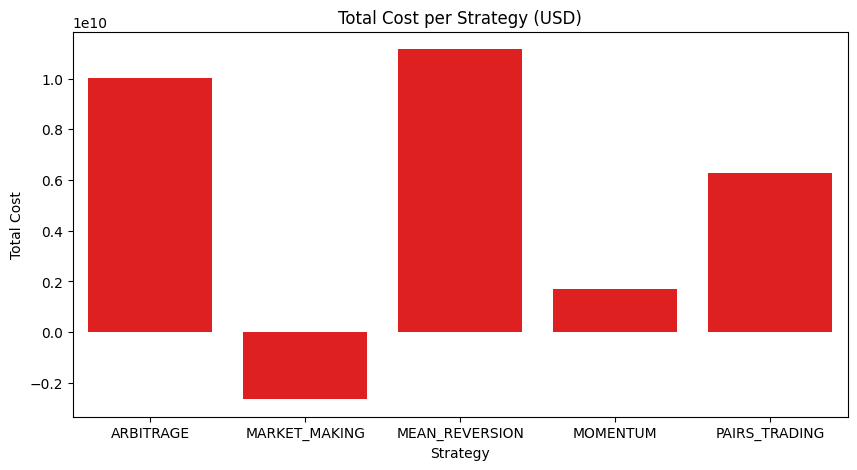

In [12]:
plt.figure(figsize=(10,5))
sns.barplot(data=strategy_perf, x="strategy", y="avg_slippage_bps", color="orange")
plt.title("Average Slippage per Strategy (bps)")
plt.ylabel("Avg Slippage (bps)")
plt.xlabel("Strategy")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=strategy_perf, x="strategy", y="total_cost", color="red")
plt.title("Total Cost per Strategy (USD)")
plt.ylabel("Total Cost")
plt.xlabel("Strategy")
plt.show()

Recommendations

In [13]:
recommendations = []

# Slippage check
if weekly["avg_slippage_bps"].mean() > 20:  # 20 bps = 0.2%
    recommendations.append("High average slippage detected. Consider improving execution methods.")
else:
    recommendations.append("Slippage under control. Maintain current execution strategy.")

# Cost check
if weekly["total_cost"].mean() > weekly["total_pnl"].mean() * 0.1:
    recommendations.append("Costs are eating more than 10% of P&L. Try reducing commissions or slippage.")
else:
    recommendations.append("Costs are within acceptable limits.")

# Strategy performance check
worst_strategy = strategy_perf.loc[strategy_perf["avg_slippage_bps"].idxmax(), "strategy"]
recommendations.append(f"Worst Strategy '{worst_strategy}' shows highest slippage. Review trading logic or order sizes.")

best_strategy = strategy_perf.loc[strategy_perf["total_pnl"].idxmax(), "strategy"]
recommendations.append(f"Best Strategy '{best_strategy}' delivered the best P&L.")

print("=== Recommendations ===")
for r in recommendations:
    print(r)


=== Recommendations ===
Slippage under control. Maintain current execution strategy.
Costs are eating more than 10% of P&L. Try reducing commissions or slippage.
Worst Strategy 'MEAN_REVERSION' shows highest slippage. Review trading logic or order sizes.
Best Strategy 'MOMENTUM' delivered the best P&L.


Save Reports

In [14]:
weekly.to_csv("weekly_tca_summary.csv", index=False)

# Save Excel report with multiple sheets
with pd.ExcelWriter("Weekly_TCA_Report.xlsx") as writer:
    weekly.to_excel(writer, sheet_name="weekly_summary", index=False)
    trades.head(200).to_excel(writer, sheet_name="sample_trades", index=False)
    strategy_perf.to_excel(writer, sheet_name="strategy_perf", index=False)

print("Reports saved: weekly_tca_summary.csv & Weekly_TCA_Report.xlsx")

Reports saved: weekly_tca_summary.csv & Weekly_TCA_Report.xlsx
